# Permuted MNIST KFAC EWC

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import OrderedDict

from utils import mlp,train_test_model
from utils.ewc_utils.onlineEWC import OnlineEWC
from utils.ewc_utils.sketchEWC import SketchEWC
from utils.ewc_utils.kfacEWC import KfacEWC
from utils.ewc_utils.ToyExampleEWC import FullEWC, LowRankEWC, MinorDiagonalEWC, BlockDiagonalEWC

from data.permuted_MNIST_test1 import get_permuted_mnist

import os

results_folder='perm_mnist_test/'

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set configurations

In [2]:
epochs = 20
lr = 1e-4
batch_size = 100 
num_task = 2

seed = 0
device='cuda:0'

## Load dataset

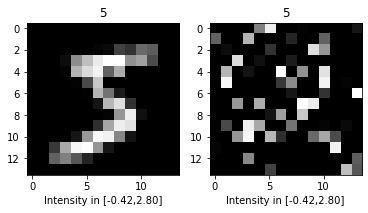

In [4]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# per_task_rotation = 180.0 / num_task
# train_loader, test_loader = get_rotated_mnist(num_task,batch_size,
#                                               num_workers=4)
train_loader, test_loader = get_permuted_mnist(num_task,batch_size,num_workers=4)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(14,14))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
# plt.show()

## Model definition

In [5]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    Adopted (but slightly different) from https://github.com/activatedgeek/LeNet-5/blob/master/lenet.py
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5), padding=2)),
            ('relu1', nn.ReLU()),
            ('s1', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c2 = nn.Sequential(OrderedDict([
            ('c2', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        self.c3 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu3', nn.ReLU())
        ]))
        self.f4 = nn.Sequential(OrderedDict([
            ('f4', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))
        self.f5 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(84, 10))
        ]))

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

In [6]:
class Model(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super(Model, self).__init__()

        self.net = nn.Sequential(OrderedDict([
            ('f1', nn.Linear(196, 40)),
            ('relu1', nn.ReLU()),
            ('f2', nn.Linear(40, 40)),
            ('relu2', nn.ReLU()),
            ('f3', nn.Linear(40, 40)),
            ('relu3', nn.ReLU()),
            ('f4', nn.Linear(40, 40)),
            ('relu4', nn.ReLU()),
            ('f5', nn.Linear(40, 40)),
            ('relu5', nn.ReLU()),
            ('f6', nn.Linear(40, 40)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(40, 40)),
            ('relu7', nn.ReLU()),
            ('f8', nn.Linear(40, 40)),
            ('relu8', nn.ReLU()),
            ('f9', nn.Linear(40, 40)),
            ('relu9', nn.ReLU()),
            ('f10', nn.Linear(40, 10))
        ]))

    def forward(self, x):
#         x = x.view(x.size(0), -1)
        x = self.net(x)
        return x
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight,gain=np.sqrt(2))
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def reset(self):
        self.net.apply(self.init_weights)

## Set model

In [7]:
model = Model()
print(model)

d=0
for n, p in model.named_parameters():
    print(n, p.data.view(-1).shape[0])
    d+=p.data.view(-1).shape[0]
print(d)

Model(
  (net): Sequential(
    (f1): Linear(in_features=196, out_features=40, bias=True)
    (relu1): ReLU()
    (f2): Linear(in_features=40, out_features=40, bias=True)
    (relu2): ReLU()
    (f3): Linear(in_features=40, out_features=40, bias=True)
    (relu3): ReLU()
    (f4): Linear(in_features=40, out_features=40, bias=True)
    (relu4): ReLU()
    (f5): Linear(in_features=40, out_features=40, bias=True)
    (relu5): ReLU()
    (f6): Linear(in_features=40, out_features=40, bias=True)
    (relu6): ReLU()
    (f7): Linear(in_features=40, out_features=40, bias=True)
    (relu7): ReLU()
    (f8): Linear(in_features=40, out_features=40, bias=True)
    (relu8): ReLU()
    (f9): Linear(in_features=40, out_features=40, bias=True)
    (relu9): ReLU()
    (f10): Linear(in_features=40, out_features=10, bias=True)
  )
)
net.f1.weight 7840
net.f1.bias 40
net.f2.weight 1600
net.f2.bias 40
net.f3.weight 1600
net.f3.bias 40
net.f4.weight 1600
net.f4.bias 40
net.f5.weight 1600
net.f5.bias 40
net.

## Train Naive SGD

In [8]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = Model().to(device)
model.reset()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Perform training
loss, acc = {}, {}
for task in tqdm(range(num_task)):
    loss[task] = []
    acc[task] = []
    for _ in tqdm(range(epochs)):
        model.train()
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss[task].append(train_test_model.train_classifier(model=model,
                                                            optimizer=optimizer,
                                                            data_loader=train_loader[task],
                                                            device=device))            
        for sub_task in range(task + 1):
            acc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))

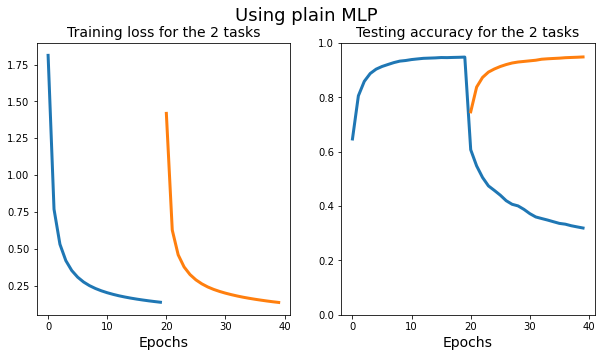

In [9]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using plain MLP',fontsize=18)
plt.show()

## Train diagonal EWC

In [63]:
ewc_alpha=0.25
ewc_importance = 1e8
n_sketch = 50

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = Model().to(device)
model.reset()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

loss_ewc, acc_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_ewc[task] = []
    acc_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        ewc = OnlineEWC(model,device=device,alpha=ewc_alpha)
        loss_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=ewc_importance,
                                                                      device=device))            
        for sub_task in range(task + 1):
            acc_ewc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))

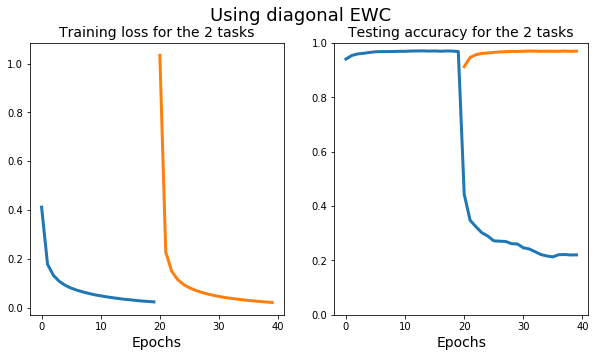

In [64]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using diagonal EWC',fontsize=18)
plt.show()

## Train sketched EWC

In [43]:
sketch_ewc_alpha=0.25
sketch_ewc_importance = 1e4
n_sketch = 50

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a convnet model
model = Model().to(device)
model.reset()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

sketch_ewc = SketchEWC(model,device=device,alpha=sketch_ewc_alpha,n_bucket=n_sketch)
## performing training
loss_sketch_ewc, acc_sketch_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_ewc[task] = []
    acc_sketch_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=sketch_ewc,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=sketch_ewc_importance,
                                                                    device=device))
        for sub_task in range(task + 1):
            acc_sketch_ewc[sub_task].append(train_test_model.test_classifier(model=sketch_ewc.model,
                                                                      data_loader=test_loader[sub_task],
                                                                      device=device))
    sketch_ewc.consolidate(train_loader[task])

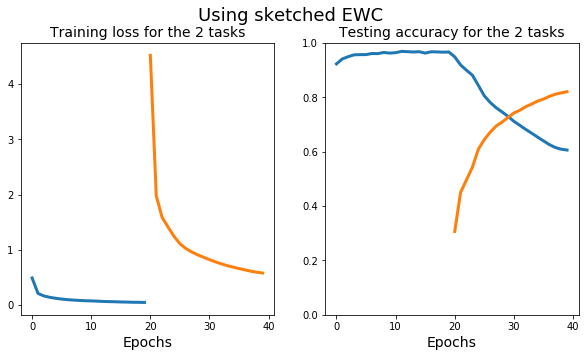

In [45]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_sketch_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using sketched EWC',fontsize=18)
plt.show()

## Train k-fac EWC

In [39]:
kfac_ewc_alpha=0.25
kfac_ewc_importance = 1e4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a convnet model
model = Model().to(device)
model.reset()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

kfac_ewc = KfacEWC(model,device=device,decay=1-kfac_ewc_alpha,weight=kfac_ewc_alpha)
## performing training
loss_kfac_ewc, acc_kfac_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_kfac_ewc[task] = []
    acc_kfac_ewc[task] = []
    
    kfac_ewc.reset_current_cov()
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_kfac_ewc[task].append(train_test_model.kfac_train_classifier(
            regularizer=kfac_ewc,
            optimizer=optimizer,
            data_loader=train_loader[task],
            importance=kfac_ewc_importance,
            device=device))
        for sub_task in range(task + 1):
            acc_kfac_ewc[sub_task].append(train_test_model.test_classifier(
                model=kfac_ewc.model,
                data_loader=test_loader[sub_task],
                device=device))
    kfac_ewc.consolidate()

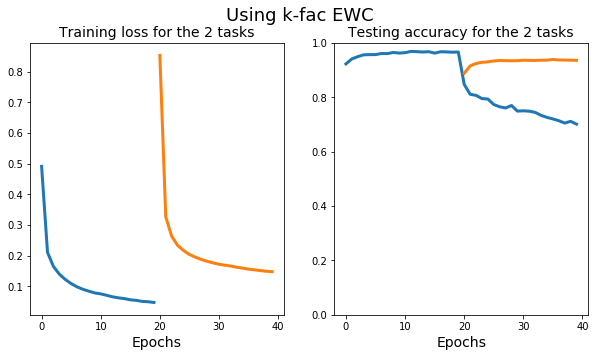

In [40]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_kfac_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_kfac_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using k-fac EWC',fontsize=18)
plt.show()

## Train full EWC

In [10]:
full_ewc_alpha=0.25
full_ewc_importance=1e4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model = Model().to(device)
model.reset()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

full_ewc= FullEWC(model,device=device,alpha=full_ewc_alpha)
## performing training
loss_full_ewc, acc_full_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_full_ewc[task] = []
    acc_full_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_full_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=full_ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=full_ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_full_ewc[sub_task].append(train_test_model.test_classifier(model=full_ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    if not task == num_task - 1: 
        full_ewc.consolidate(train_loader[task])


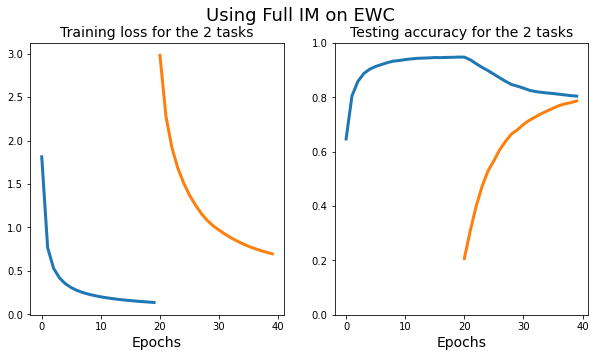

In [11]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_full_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_full_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using Full IM on EWC',fontsize=18)
plt.show()

## Train block-diagonal EWC

In [12]:
block_diagonal_ewc_alpha=0.25
block_diagonal_ewc_importance=1e4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model = Model().to(device)
model.reset()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

block_diagonal_ewc= BlockDiagonalEWC(model,device=device,alpha=block_diagonal_ewc_alpha)
## performing training
loss_block_diagonal_ewc, acc_block_diagonal_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_block_diagonal_ewc[task] = []
    acc_block_diagonal_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_block_diagonal_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=block_diagonal_ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=block_diagonal_ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_block_diagonal_ewc[sub_task].append(train_test_model.test_classifier(model=block_diagonal_ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    if not task == num_task - 1: 
        block_diagonal_ewc.consolidate(train_loader[task])

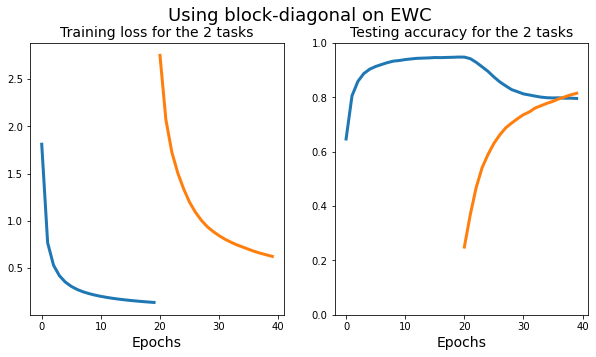

In [13]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_block_diagonal_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the %d tasks'%(num_task),fontsize=14)
for t, v in acc_block_diagonal_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the %d tasks'%(num_task),fontsize=14)
fig.suptitle('Using block-diagonal on EWC',fontsize=18)
plt.show()

## Visualize block-diagonal vs. k-fac